### ADS Final Project, Credit Risk Classification 

### Baxter Romero, Michael Sexton

### 0. Data / Library Load  + Preprocessing

In [27]:
#LOAD AND PREPROCESS DATA

#Libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import itertools 
loans_df = pd.read_csv("loan_data.csv")

#loans_df['annual_inc'] = np.exp(loans_df['log.annual.inc']) #keep log value to account for outliers


print(loans_df.shape)
loans_df.head()

(9578, 14)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [28]:
#print(loans_df.dtypes)
#print(loans_df.isnull().sum())
#print(loans_df.duplicated().sum())
#print(loans_df['annual_inc'].describe())
#print (loans_df['fico'].describe())
#print(loans_df['revol.util'].describe())
#
#sns.boxplot(x=loans_df['dti'])  # Debt-to-Income ratio
#plt.title("Outlier check: DTI")
#plt.show()
#loans_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

#remove rows where credit lines totals are >100%
loans_df = loans_df[loans_df['revol.util'] <= 100]

loans_df.head(5)


,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In this preprocessing step, the dataset is loaded and inspected for outliers, with particular attention to revol.util, where rows exceeding 100% credit utilization are removed to eliminate potential anomalies or data quality issues. The log.annual.inc feature is retained in its logarithmic form to preserve the effect of income while reducing the influence of extreme outliers. Total preprocessing analysis includes things such as missing values, duplicate rows, data types, and debt-to-incomeratio distribution.

### 1a . KMeans Clustering

Testing the core hypothesis — that borrowers can be grouped based on financial similarity.

In [29]:
#KMEANS CODE + RESULTS
features = ["fico", "int.rate", "dti", "log.annual.inc", "revol.util"]
X = loans_df[features]

def distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [30]:
# KMeans clustering adapted from Pokémon notebook
def kmeans(df, k=4, tol=0.05): 
    """
    df: dataframe of numeric features (e.g. fico, dti, etc.)
    k: number of clusters
    tol: stopping tolerance based on reconstruction error
    Returns: centroids, cluster assignments, list of errors per iteration
    """
    np.random.seed(42)  #for reproducibility

    centroids = df.sample(n=k, random_state=42).values.tolist()  #init centroids
    clusters = [-1] * len(df)  #init all to unassigned
    meanerror = []  #track re
    prev_error = float('inf')

    while True:         #Step 1: Assign clusters

        for i in range(len(df)):
            dists = [distance(df.iloc[i].values, cent) for cent in centroids]
            clusters[i] = np.argmin(dists)  #assign to nearest centroid

        new_centroids = []         #Step 2: Recompute centroids
        for j in range(k):
            cluster_points = [df.iloc[i].values for i in range(len(df)) if clusters[i] == j]
            if cluster_points:
                new_centroids.append(np.mean(cluster_points, axis=0).tolist())
            else:
                new_centroids.append(centroids[j])  #edge case check

        #Step 3: Compute reconstruction error
        error = np.mean([distance(df.iloc[i].values, centroids[clusters[i]]) for i in range(len(df))])
        meanerror.append(error)

        #Step 4: Convergence check
        if abs(prev_error - error) <= tol:
            break

        #Update for next iter
        prev_error = error
        centroids = new_centroids

    return centroids, clusters, meanerror



In [31]:
features = ["fico", "int.rate", "dti", "log.annual.inc", "revol.util", "pub.rec", "days.with.cr.line", "delinq.2yrs"]
X = loans_df[features]

centroids, clusters, errors = kmeans(X, k=7, tol=0.01)
loans_df["cluster"] = clusters

# Group by cluster and calculate mean for only the selected features
cluster_means = loans_df.groupby('cluster')[features].mean()


sorted_cluster_means = cluster_means.sort_values(by='fico', ascending=True)


print(sorted_cluster_means)


               fico  int.rate        dti  log.annual.inc  revol.util  \
cluster                                                                
3        692.190896  0.131584  10.616358       10.428024   44.224501   
4        704.631188  0.122374  12.876832       10.783420   47.338475   
5        711.291524  0.122641  13.094422       10.985150   48.238917   
2        717.180204  0.120873  13.009688       11.134209   47.687031   
0        721.285714  0.119109  12.759503       11.198230   46.777577   
6        724.495948  0.117947  12.778233       11.191682   43.734506   
1        736.103586  0.115508  12.367928       11.115222   37.929880   

          pub.rec  days.with.cr.line  delinq.2yrs  
cluster                                            
3        0.017621        1459.803200     0.079295  
4        0.034653        2795.619121     0.142079  
5        0.067637        4029.536601     0.148545  
2        0.093599        5369.423996     0.201721  
0        0.091320        7021.755274   

From a brief examination of these cluster means we can see that there is a direct relationship between fico score and days with credit line. In addition to annual log income is a clear trend however there are some factors which don't apply or are key to our understanding of risk factors and how we can create a better aggregate risk score. Those factors are pub.rec (the borrower's number of derogatory public records) which interestingly increase as fico score increases. Additionally, debt-to-income doesn't appear to translate to fico score either, as it peaks in the mean of all clusters and decreases on either tail. We would expect hope to see that those with a higher debt-to-income have a lower overall score but this seems to not be the case.

Here we can see that there is a clear trend in each cluster, and certain features are associated, we will perform Principal component analysis utilizing the prebuilt package from sklearn to visualize the trend.

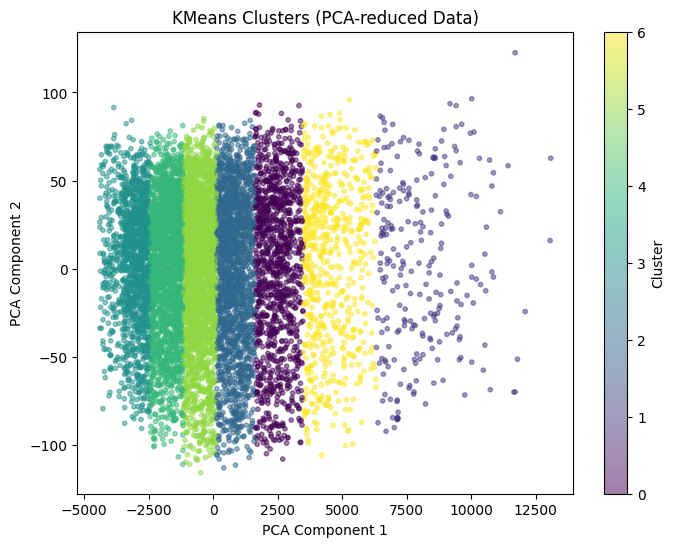

In [32]:
# here i am importing Principal component analysis to aid in the visualization of the seperation of our data. i want to validate that
# we are correctly seeing trends and the data itself is patterned and can be seperated into distinct clusters
from sklearn.decomposition import PCA


pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X)  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=loans_df['cluster'], cmap='viridis', s=10, alpha=0.5)
plt.title("KMeans Clusters (PCA-reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


#### Elbow Test - Scikit Learn

Used scikit-learn to find the elbow fast, then ran  custom kmeans() for interpretation on the best k. Very long runtime with 5+ iterations per value of k, Across multiple values of k (1–10) on a dataset with 10,000 rows and multiple features.

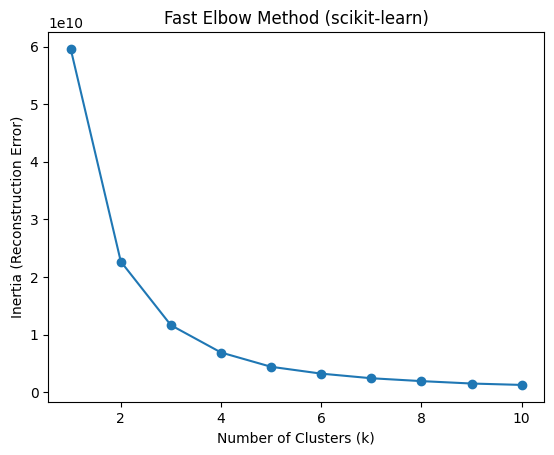

In [33]:
from sklearn.cluster import KMeans

errors = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X)
    errors.append(model.inertia_)  # Sum of squared distances to centroids

plt.plot(range(1, 11), errors, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Reconstruction Error)")
plt.title("Fast Elbow Method (scikit-learn)")
plt.show()

#### dti vs interest rate

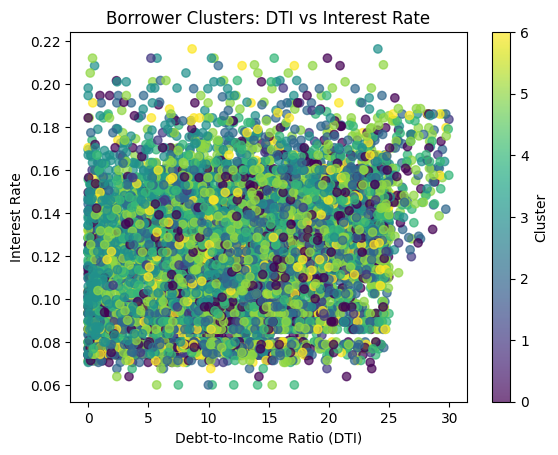

In [34]:
plt.scatter(loans_df['dti'], loans_df['int.rate'], c=loans_df['cluster'], alpha=0.7)
plt.xlabel("Debt-to-Income Ratio (DTI)")
plt.ylabel("Interest Rate")
plt.title("Borrower Clusters: DTI vs Interest Rate")
plt.colorbar(label='Cluster')
plt.show()

#### fico vs interest rate

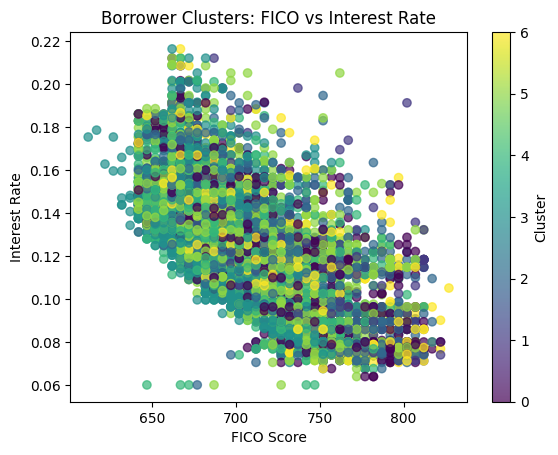

In [35]:
plt.scatter(loans_df['fico'], loans_df['int.rate'], c=loans_df['cluster'], alpha=0.7)
plt.xlabel("FICO Score")
plt.ylabel("Interest Rate")
plt.title("Borrower Clusters: FICO vs Interest Rate")
plt.colorbar(label='Cluster')
plt.show()

#### log.annual.inc vs dti

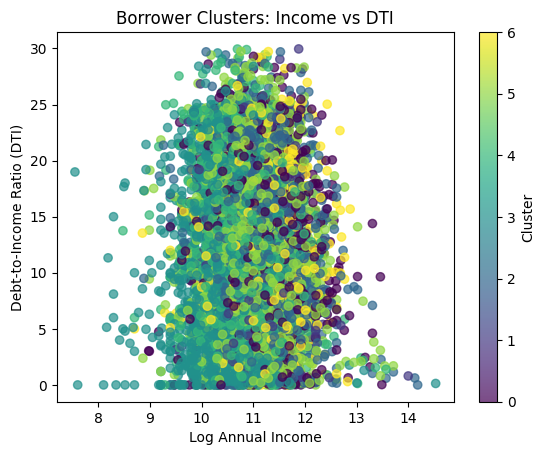

In [36]:
plt.scatter(loans_df['log.annual.inc'], loans_df['dti'], c=loans_df['cluster'], alpha=0.7)
plt.xlabel("Log Annual Income")
plt.ylabel("Debt-to-Income Ratio (DTI)")
plt.title("Borrower Clusters: Income vs DTI")
plt.colorbar(label='Cluster')
plt.show()

Explanation for techniques used

### 1b . Gaussian Mixture Model Clustering

We also want to validate our results from KMeans and see if there are any other trends to keep in mind with further researching.

In [40]:
# GMM adapted from HW 4 (pokemon hw) to support multidimensional data


def GMM(dat, k):
    ##
    #Comments will reference slides 26-31 from Feb 9
    
    """Define the variables we will use in the Algorithm"""
    covars = np.zeros((k, X.shape[1], X.shape[1]))  # (k, n_features, n_features)
    
    means = np.zeros((k, X.shape[1]))  # (k, n_features)

    
    #This represents W_m (weights/likelihood of each component) (slide 26 bottom)
    p_class=np.zeros(k)
    
    #This represents P(x_i | cluster = m), or Φ(x_i | μ_m, Σ_m) (slide 27)
    #During the Expectation step, we will use this to derive p̂_mi (or p_class_given_data) as shown on slide 27
    #p_class_given_data will be the same shape
    p_data_given_class=np.zeros((len(dat),k))

    
    """Initialize means, covs, p_classes"""
    #initializations of starting points (used to set the initial means below)
    init_idx=np.random.choice(range(len(dat)), size=k, replace=False)
    
    #Initialize the covariance matrix, the means, and the p_class for each of k components (dims)
    for dim in range(k):
        #Set the cov matrix of each component to the cov of the entire dataset (slide 26)
        covars[dim,:,:]=np.cov(np.transpose(dat))

        #Set initial means to initial chosen data points (slide 26)
        means[dim,:]=dat.iloc[init_idx[dim]]
        
        #Give each component equal weighting / likelihood to start (slide 26)
        p_class[dim]=1/k
        
    """Now Iterate"""
    #Now we start our for loop, where-in we'll alernate between: (1) Expecation Step and (2) Maximization Step
    #Note - 50 steps is fine, no requirement to check for convergence on this HW
    for step in range(50):  
        
        """Expectation Step (Slide 27)"""
        #Your code here
        #iterate over each point in the data
        for i in range(len(dat)):
            #iterate over each k
            for m in range(k):
                #for each point and each k, calculate the probability that it belongs to that given k
                p_data_given_class[i,m] = stats.multivariate_normal.pdf(dat.iloc[i], mean = means[m], cov = covars[m], allow_singular=True)
            #normalize it to find the best fit
            p_data_given_class[i,:] = p_class*p_data_given_class[i,:]/np.sum(p_class*p_data_given_class[i,:])
        
        """Maximization Step (Slide 29-30)"""
        #Your code here
        for m in range(k):
            #count the number of points in a given cluster
            nm = np.sum(p_data_given_class[:,m])
            
            #find the weights of the points in that cluster
            wm = nm/ len(dat)
            
            #updating means by applying the formula (np.newaxis is used to allow for proper division bc of sizing discrepancy)
            means[m] = np.dot(p_data_given_class[:, m], dat) / nm

            
            #updating covars
            x_minus_mu = dat - means[m]
            outer_product = p_data_given_class[:, m][:, np.newaxis] * x_minus_mu
            covars[m] = np.dot(outer_product.T, x_minus_mu) / nm

    
    """Once we're done with our for loop, we compute the mean dist (This formula is given in the HW below in Part B)"""
    #Your code here
    mean_dist = 0
    for m in range(k):
        x_minus_mu = dat - means[m]
        mean_dist += np.sum(p_data_given_class[:, m] * np.sum(x_minus_mu ** 2, axis=1))

    mean_dist = np.sqrt(mean_dist / len(dat))

    p_class_given_data = p_data_given_class
    #Return all the needed variables
    return p_class_given_data, means, covars, p_class, mean_dist

We will run an elbow graph to find best k for our dataset.

In [ ]:
k_pref = 2
features = [ "dti","revol.util", "days.with.cr.line", "delinq.2yrs"]
X = loans_df[features]
p_class_given_data, means, covars, p_class, mean_dist = GMM(X, k_pref)
cluster_assigned = np.argmax(p_class_given_data, axis=1)

plt.scatter(df['lat'], df['lng'], c = cluster_assigned, marker = 'o')
plt.title("Clusters for GMM using K=2")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

In [41]:
mean_dist=np.zeros(9)
X = loans_df[features]
for k in range(1,9):
    _,_,_,_,dist = GMM(X,k)
    mean_dist[k]=dist
    
plt.plot(range(1,9),mean_dist[1:])
plt.title("Weighted Mean Distance for value of k")
plt.ylabel("Weighted Mean Distance")
plt.xlabel("K")

KeyboardInterrupt: 

### 2. Feature Analysis + Thresholding

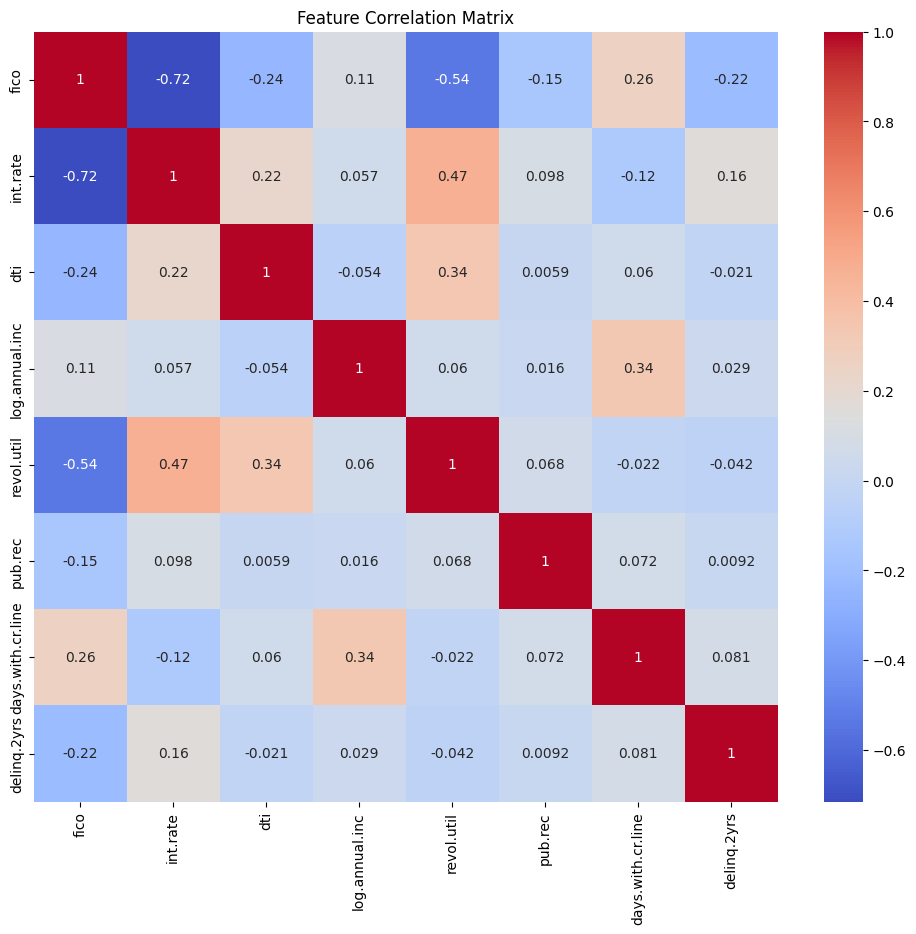

In [42]:
#FIND FEATURES WITH LOWEST SUM OF SQUARED ERROR, IDEALLY HAVE HIGH COHESION AND MAXIMIZE CLUSTER SEPARATION

# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


This correlation matrix further tells us which features are critical to our newly created risk factor. Delinquincy is our y variable, since at the end of the day, we wish to determine if a client will repay or be late on their loan, although this is inheritly biased since those who have filed delinquency likely have had a longer credit history, this still allows us to determine feature importance. Specifically, certain elements such as revolving utilization, debt-to-income ratio,all have a correlation greater than 0.2, therefore we will try to use these for our new model.

### 3. Market Basket Analysis (Apriori)

In [43]:
#create behavioral flags
# all flags were created based on average US citizen
loans_df['high_dti'] = (loans_df['dti'] > 20).astype(int)
loans_df['high_revol_util'] = (loans_df['revol.util'] > 50).astype(int)
loans_df['delinq_past_2yrs'] = (loans_df['delinq.2yrs'] > 0).astype(int)
loans_df['short_credit_history'] = (loans_df['days.with.cr.line'] < 3000).astype(int)
loans_df['high_interest_rate'] = (loans_df['int.rate'] > 0.13).astype(int)
loans_df['low_income'] = (loans_df['log.annual.inc'] < 10.8).astype(int)
loans_df['low_fico']= (loans_df['fico'] > 715).astype(int)
behavior_cols = ['high_dti', 'high_revol_util', 'delinq_past_2yrs', 
                 'short_credit_history', 'high_interest_rate', 'low_income']

#build txns for borrowers
transactions_all = []

for _, row in loans_df.iterrows():
    transaction = []
    for col in behavior_cols:
        if row[col] == 1:
            transaction.append(col)
    transactions_all.append(transaction)

#apriori logic from hw5

def frequent_single_items(recipes, support_threshold):
    item_counts = {}
    for recipe in recipes:
        for item in recipe:
            item_counts[item] = item_counts.get(item, 0) + 1

    frequent_items = []
    total_recipes = len(recipes)
    for item, count in item_counts.items():
        if count / total_recipes >= support_threshold:
            frequent_items.append((item, count))
    return frequent_items

def frequent_pairs(recipes, frequent_single_items, support_threshold):
    from collections import defaultdict

    frequent_item_indices = {item[0] for item in frequent_single_items}
    pair_counts = defaultdict(int)
    total_recipes = len(recipes)

    for recipe in recipes:
        frequent_recipe = list(set(recipe) & frequent_item_indices)
        for i in range(len(frequent_recipe)):
            for j in range(i + 1, len(frequent_recipe)):
                pair = tuple(sorted((frequent_recipe[i], frequent_recipe[j])))
                pair_counts[pair] += 1

    frequent_pairs = []
    for pair, count in pair_counts.items():
        if count / total_recipes >= support_threshold:
            frequent_pairs.append((pair, count))
    return frequent_pairs

#runner + params

#thresholds
single_support_threshold = 0.01  # 1%
pair_support_threshold = 0.005   # 0.5%

frequent_singles_all = frequent_single_items(transactions_all, single_support_threshold)
frequent_pairs_all = frequent_pairs(transactions_all, frequent_singles_all, pair_support_threshold)

print("Top Frequent Single Behaviors (All Borrowers):")
for item, count in sorted(frequent_singles_all, key=lambda x: x[1], reverse=True):
    print(f"{item}: {count}")

print("\nTop Frequent Behavior Pairs (All Borrowers):")
for pair, count in sorted(frequent_pairs_all, key=lambda x: x[1], reverse=True)[:10]:
    print(f"{pair}: {count}")

#Starter code to run Apriori *by Cluster* to find cluster-specific bundles

# Choose a cluster (example: cluster 0)
#target_cluster = 0
#
#transactions_cluster = []
#cluster_df = loans_df[loans_df['cluster'] == target_cluster]
#
#for _, row in cluster_df.iterrows():
#    transaction = []
#    for col in behavior_cols:
#        if row[col] == 1:
#            transaction.append(col)
#    transactions_cluster.append(transaction )

# Run Apriori for this cluster

#frequent_singles_cluster = frequent_single_items(transactions_cluster, single_support_threshold)
#frequent_pairs_cluster = frequent_pairs(transactions_cluster, frequent_singles_cluster, pair_support_threshold)

#print(f"\nTop Frequent Single Behaviors (Cluster {target_cluster}):")
#for item, count in sorted(frequent_singles_cluster, key=lambda x: x[1], reverse=True):
#    print(f"{item}: {count}")
#
#print(f"\nTop Frequent Behavior Pairs (Cluster {target_cluster}):")
#for pair, count in sorted(frequent_pairs_cluster, key=lambda x: x[1], reverse=True)[:10]:
#    print(f"{pair}: {count}")


Top Frequent Single Behaviors (All Borrowers):
high_revol_util: 4378
low_income: 3823
high_interest_rate: 3711
short_credit_history: 2639
high_dti: 1620
delinq_past_2yrs: 1119

Top Frequent Behavior Pairs (All Borrowers):
('high_interest_rate', 'high_revol_util'): 2462
('low_income', 'short_credit_history'): 1710
('high_revol_util', 'low_income'): 1661
('high_interest_rate', 'low_income'): 1441
('high_interest_rate', 'short_credit_history'): 1200
('high_revol_util', 'short_credit_history'): 1178
('high_dti', 'high_revol_util'): 1060
('high_dti', 'high_interest_rate'): 856
('high_dti', 'low_income'): 757
('delinq_past_2yrs', 'high_interest_rate'): 653


We created binary behavioral flags (e.g., high DTI, low income) by thresholding key financial features. Each borrower was then represented as a "basket" of their behaviors, forming transactions for market basket analysis. Using the Apriori algorithm, we identified the most frequent individual behaviors and behavior bundles across all borrowers and within specific clusters.

we found that high revolving utilization, low income, and high interest rates are the most common individual financial challenges among borrowers. The most frequent behavior bundle shows that borrowers with high revolving utilization often also face high interest rates, compounding financial strain. Many low-income borrowers also have short credit histories, suggesting early-stage or disadvantaged credit profiles. Overall, high debt-to-income and past delinquencies frequently co-occur with other financial risks, revealing distinct clusters of borrower vulnerability.

### Decision Tree Feature Engineering

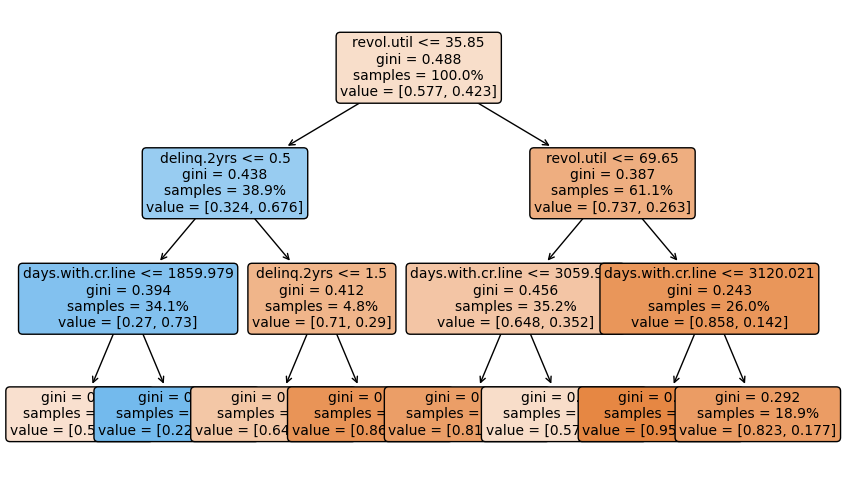

In [70]:
#FINALIZE WHICH FEATURES OR COMBINATIONS DRIVE RISK. DECISION TREE/STUMP GIVE CLEAR SIGNAL ON WHICH FEATURES MATTER BASED ON CLEANED/FILTERED DATA

# utilizing sklearn's prebuilt decision tree classifier. this will aid our goals in our project
#  however we did not cover this in class so I will just be using the prebuilt method
# decision tree classifiers at this step of the project allow us to dive into the market basket analysis we did and see
# which individual features or clusters of features are more important to determining if a client will default on their loan.
from sklearn.tree import DecisionTreeClassifier, plot_tree

# individual features of interest
behavior_features = [  "dti", "log.annual.inc", "revol.util", "pub.rec", "days.with.cr.line", "delinq.2yrs"]
#"revol.util",  "delinq.2yrs"

# paired features (cannot include fico or interest rate since they are retroactively set, we want to do prediction here)
# these pairs were taken directly from apriori analysis since they are the top frequent pairs. we will be ranking them based o
# 1
loans_df["low_income_and_short_credit_history"] = loans_df["low_income"] * loans_df["short_credit_history"]
# 2
loans_df["high_util_and_low_income"] =  loans_df["high_revol_util"] * loans_df["low_income"]
# 3
loans_df["high_util_and_short_credit_history"] = loans_df["high_revol_util"] * loans_df["short_credit_history"]
# 4
loans_df["high_dti_and_high_revol_util"] = loans_df["high_dti"] * loans_df["high_revol_util"]
# 5
loans_df["high_dti_and_low_income"] =  loans_df["high_dti"] * loans_df["low_income"] 

#behavior_features = [ "high_util_and_low_income", "high_dti_and_high_revol_util", "high_dti_and_low_income", "low_income_and_short_credit_history", "high_util_and_low_income"]
# high_util_and_short_credit_history, 

# initializing X and y
X = loans_df[behavior_features] 
y = loans_df["low_fico"]

# initializing model
tree = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=50)

# fitting
tree.fit(X, y)

# plotting
plt.figure(figsize=(10,6))
plot_tree(tree, feature_names=X.columns, filled=True, proportion=True, rounded=True, fontsize=10)
plt.show()



Features which cannot be used to determine FICO: interest rate, because they are set by the banks at time of loan (or afterwards). This is not a feature which would impact delinquency in the real world, rather a element that is used by banks to determine if a loan candidate is a good candidate or not.

Interestingly revolving utilization is the biggest individual impact on feature selection followed by delinquincy, and days with credit line. When examining frequent itemsets, we find that high utilization and low credit history play the biggest role, followed by low income and high utilization, then high utilization and low income.

### Risk Profiling and Validation

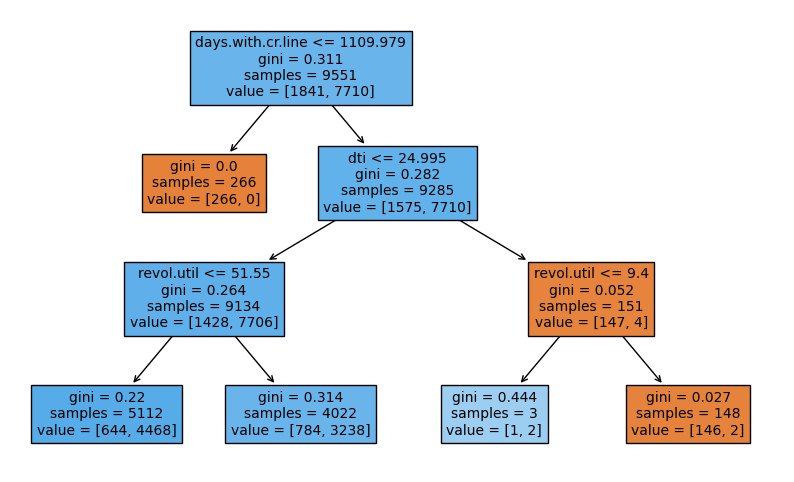

In [67]:
#VALIDATE ENTIRE PIPELINE BY CHECKING IF APPROACH BETTER EXPLAINS OR PREDICTS RISK COMPARED TO FICO

# we will perform a similar decision tree analysis but use the y vector of credit policy, which is whether or not the loan company
# decided to grant the loan to the applicant. here we would like to see that the loan policy follows a similar trend in importance as above
# since that would mean that the factors which should influence fico score directly reflect if a loan was given. FICO score was created
# in an attempt to give a numeric expression of risk factor when distributing loans or credit, thus we want to see a similar pattern 
# of importance.

# individual features of interest
behavior_features = [  "dti", "log.annual.inc", "revol.util", "pub.rec", "days.with.cr.line", "delinq.2yrs"]


# paired features (cannot include fico or interest rate since they are retroactively set, we want to do prediction here)
# these pairs were taken directly from apriori analysis since they are the top frequent pairs. we will be ranking them based o
# 1
loans_df["low_income_and_short_credit_history"] = loans_df["low_income"] * loans_df["short_credit_history"]
# 2
loans_df["high_util_and_low_income"] =  loans_df["high_revol_util"] * loans_df["low_income"]
# 3
loans_df["high_util_and_short_credit_history"] = loans_df["high_revol_util"] * loans_df["short_credit_history"]
# 4
loans_df["high_dti_and_high_revol_util"] = loans_df["high_dti"] * loans_df["high_revol_util"]
# 5
loans_df["high_dti_and_low_income"] =  loans_df["high_dti"] * loans_df["low_income"] 

#behavior_features = [ "high_dti_and_high_revol_util", "high_util_and_low_income",  "high_dti_and_low_income", "low_income_and_short_credit_history", "high_util_and_short_credit_history", "high_util_and_low_income"]
# initializing X and y
X = loans_df[behavior_features] 
y = loans_df["credit.policy"]

# initializing model
tree = DecisionTreeClassifier(max_depth=3, random_state=42)

# fitting
tree.fit(X, y)

# plotting
plt.figure(figsize=(10,6))
plot_tree(tree, feature_names=X.columns, filled=True, fontsize=10)
plt.show()



Here there is an interesting trend between the order of importance between the two outputs, we find that the days with credit line is of the highest importance when predicting credit policy, while for fico score, revolving utilization is more important, additionally debt to income ratio is of the next most importance followed revolving utilization. 

When examining pairs we find that high debt to income and high revolving utilization play the most important role, followed by low income and short credit history and high utilization and short credit history. This compares to high utilization and low credit history play the biggest role, followed by low income and high utilization, then high utilization and low income. We will examine these results more in the project writeup, however from an initial reflection on the results, we find that the length of credit history and debt to income ratio is more important to credit policy while revolving utilization and delinquincy is more important to FICO score.
